In [1]:
%matplotlib inline

import os
import pandas as pd
from tqdm import tqdm
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, './_modules')
from general_functions import clean_text, language, corpus_tool
from path_definitions import control_dir, unigrams_dir, output_dir
from db_functions import TheDB
from datetime import datetime

plt.style.use('ggplot')

/home/dev/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
cwd = os.getcwd()

In [3]:
## specifying the path to collect control:
control_path = control_dir()

Folder already exists.
/home/dev/sigo_prod/_collect_control


In [4]:
body_path = unigrams_dir()

Folder already exists.
/home/dev/sigo_prod/_text_unigrams


In [5]:
output_path = output_dir()

Folder already exists.
/home/dev/sigo_prod/_data_output


In [6]:
os.listdir(control_path)

['pid_DataCollector.dat',
 'to_data.csv',
 'logging_app.log.20200703',
 'att_data.csv',
 'logging_app.log.20200701',
 'log.csv',
 'subset_mail_error.dat',
 'mid_base.csv',
 'logging_app.log.20200705',
 'logging_app.log.20200702',
 'logging_app.log',
 'logging_app.log.20200704']

### Getting the ids for mails with error:

In [7]:
path_error = os.path.join(control_path, 'subset_mail_error.dat')
error_mails_list = []
if os.path.isfile(path_error) == True:
    df_error = pd.read_table(path_error, header = None)
    mail_list = list(set(df_error[0].tolist()))
    print(mail_list)

['171502cf6ed56cc6', '171502660d110592', '1714feb2db0b61b7', '1713c2a8dd3b6afd', '17150243722cf702', '1714143ee497d01d', '171508ec3933aa3c', '171e5e7bf2c176c2', '1714fda8db9407cf', '1714fdccd36b8bad', '17237594be2323af', '171501e56dd86d1e', '171507a5afb7d261', '1727fda70c41e214', '17151311d3a03f2f', '1727fc246a286145', '17155d34ab66320e', '17155ea49ef1d656', '17141627af77d7d6', '1714fdca49174b27', '1725df32f72030fa', '17159d71791a7dfa', '1715afb62115f602', '171508ff03adfaee', '1725e08038416eb5', '1727fd3b013e76ed']


### Reading the log

In [8]:
#path_log = os.path.join(control_path, 'logging_app.log')
#f = open(path_log, 'r')
#log_text_list = f.readlines()
#f.close()

#log_text = ' '.join(log_text_list)
#print(log_text)

### Reading the log csv

In [20]:
df_log = pd.read_csv(os.path.join(control_path, 'log.csv'), sep = '\t', encoding = 'utf-8')
df_log['date'] = pd.to_datetime(df_log['date'])
df_log = df_log.sort_values('date', ascending = False)
df_log = df_log.set_index('date')
df_log

,step_time,new_mail_counter,total_mail_counter,query_type
date,,,,
2020-07-06 22:28:36.241030,17.668253,26,21202,day
2020-07-06 22:18:17.843555,112.829502,27,21202,full
2020-07-06 22:06:24.289008,115.825443,29,21201,full
2020-07-06 21:54:27.743669,19.922323,28,21198,day
2020-07-06 21:44:07.104889,21.909947,28,21196,day
...,...,...,...,...
2020-03-03 23:50:12.700573,143.791224,48,13029,full
2020-03-03 23:36:14.584702,7201.863663,4130,12981,full
2020-03-03 17:01:42.205353,582.264245,11847,12981,full


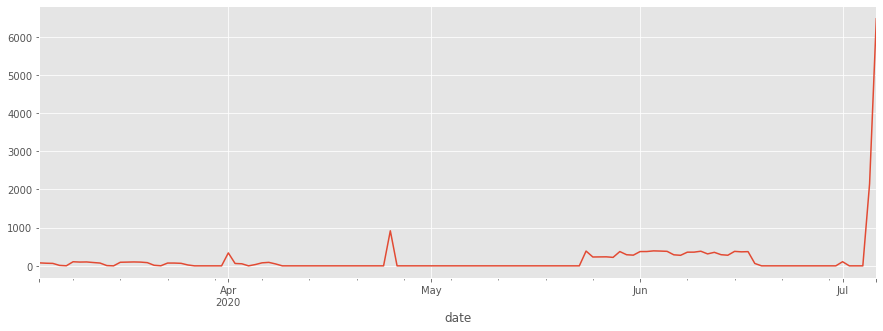

In [21]:
df_log.resample('D')['new_mail_counter'].sum()['2020-03-04':].plot(figsize = [15,5])

In [11]:
list_mail=df_log['2020-05-24']['new_mail_counter'].tolist()
print(np.sum(list_mail))

387


### Getting the full mail table

In [12]:
## bots BD connections
conn_dict = {'host':'localhost', 'database': 'brspcqadev',
             'user':'root', 'password':'quito2020'}

cqdb_prod = TheDB(conn_dict)

In [13]:
df_full = cqdb_prod.GetTable('Screening')

## converting to time object
df_full['mail_hms_received'] = pd.to_datetime(df_full['mail_hms_received']).dt.time

## converting to datetime object
df_full['mail_date_received'] = pd.to_datetime(df_full['mail_date_received'])


## unifying date and time columns into one single datetime object:
df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_date_received'].apply(str) +\
                                              ' ' + df_full['mail_hms_received'].apply(str))

df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_datetime_received'])

df_full = df_full.sort_values('mail_datetime_received', ascending = False).reset_index(drop = True)

df_full

,main_id,mail_id,thread_id,mail_date_received,mail_hms_received,mail_subject,mail_from,mail_body,mail_body_snippet,has_attachment,attachment_folder_link,case_id,external_ref_number,date_created,date_updated,checkd,mail_datetime_received
0,20431,173204e94756418c,173204e94756418c,2020-07-05 18:48:05,18:48:05,"FWD: [0-0910000031240] BR Data Request, Ext Re...",lis-latam@google.com,b'\r\n\r\nUrgent: 3 days deadline\r\n\r\nRecor...,Urgent: 3 days deadline Records #[005/2.20.000...,2,/home/dev/sigo_prod/_attachments/173204e94756418c,0-0910000031240,0002028-66.2020.8.21.0005,2020-07-05 19:31:43,2020-07-05 19:31:43,N,2020-07-05 18:48:05
1,20705,1731fb2f8e4d0333,172e8114b9fc31a2,2020-07-05 15:58:07,15:58:07,Re: [0-9910000030529] - FEDERAL - JFMG - c 202...,lis-latam@google.com,"b'Hi team,\r\n\r\nOn July 3, LE withdrew the C...","Hi team, On July 3, LE withdrew the Case on LE...",1,/home/dev/sigo_prod/_attachments/1731fb2f8e4d0333,0-9910000030529,1018233-11.2020.4.01.3800,2020-07-05 19:42:59,2020-07-05 19:42:59,N,2020-07-05 15:58:07
2,17787,1731c6b040272500,1731c6b040272500,2020-07-05 00:40:39,00:40:39,Fwd: [3-1026000030833] Novo Fornecimento de Da...,lis-latam@google.com,"b'\r\n\r\nUrgent - fines\r\n\r\nHi team,\r\n\r...","Urgent - fines Hi team, Please see below the r...",2,/home/dev/sigo_prod/_attachments/1731c6b040272500,3-1026000030833,0050664-90.2020.8.06.0034,2020-07-05 14:21:29,2020-07-05 14:21:29,N,2020-07-05 00:40:39
3,20158,1731c45e53dfea27,1731c45e53dfea27,2020-07-05 00:00:08,00:00:08,"FWD: [8-5284000030790] BR Data Request, Ext Re...",lis-latam@google.com,b'\r\n\r\nUrgent - 3 day deadline\r\n\r\nRecor...,Urgent - 3 day deadline Records # [005/2.20.00...,2,/home/dev/sigo_prod/_attachments/1731c45e53dfea27,8-5284000030790,0001977-55.2020.8.21.0005,2020-07-05 17:07:07,2020-07-05 17:07:07,N,2020-07-05 00:00:08
4,21322,1731c3e7602dd3bf,1731c3e7602dd3bf,2020-07-04 23:51:59,23:51:59,"FWD: [1-7034000030875] BR Data Request, Ext Re...",lis-latam@google.com,b'\r\n\r\nUrgent - fines\r\n\r\nRecords # [005...,Urgent - fines Records # [0050664-90.2020.8.06...,2,/home/dev/sigo_prod/_attachments/1731c3e7602dd3bf,1-7034000030875,0050664-90.2020.8.06.0034,2020-07-05 20:25:32,2020-07-05 20:25:32,N,2020-07-04 23:51:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21027,10228,16b6cb501fd2e09b,16b6cb501fd2e09b,2019-06-18 22:28:47,22:28:47,Diligência - Procuradoria da República no Rio ...,helena.rossi@carinaquito.com,"b'Dra. Carolina,\r\n\r\n \r\n\r\nConforme fala...","Dra. Carolina, Conforme falamos mais cedo, env...",1,/home/dev/sigo_prod/_attachments/16b6cb501fd2e09b,,,2020-07-01 18:47:18,2020-07-01 18:47:18,N,2019-06-18 22:28:47
21028,15808,16b6cb4361be635d,16b6cb4361be635d,2019-06-18 22:27:56,22:27:56,Diligência - Delegacia de Polícia de Goianésia...,helena.rossi@carinaquito.com,"b'Dra. Thalita,\r\n\r\n \r\n\r\nConforme falam...","Dra. Thalita, Conforme falamos, enviaremos por...",1,/home/dev/sigo_prod/_attachments/16b6cb4361be635d,,,2020-07-01 22:24:50,2020-07-01 22:24:50,N,2019-06-18 22:27:56
21029,18497,16b66762fb0fb689,16b66762fb0fb689,2019-06-17 17:22:28,17:22:28,Teste,paula.aragao@carinaquito.com,b' \r\n\r\n \r\n\r\n\r\n\r\n \r\n\r\n',,1,/home/dev/sigo_prod/_attachments/16b66762fb0fb689,,,2020-07-05 14:43:04,2020-07-05 14:43:04,N,2019-06-17 17:22:28
21030,5473,16b66603ebd89f26,16b66603ebd89f26,2019-06-17 16:58:32,16:58:32,Tips for using your new inbox,mail-noreply@google.com,b' Tips for using your new inbox\r\n[image: Go...,Hi Diligências Welcome to your Gmail inbox Sav...,1,/home/dev/sigo_prod/_attachments/16b66603ebd89f26,,,2020-07-01 14:57:03,2020-07-01 14:57:03,N,2019-06-17 16:58:32


In [14]:
#print(df_full['mail_body'][0].decode('utf-8'))

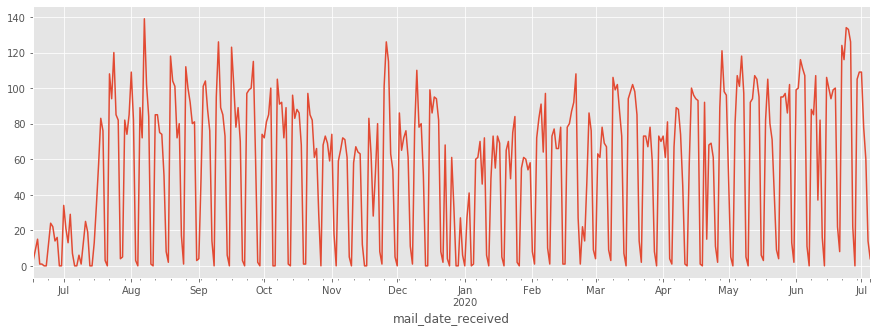

In [15]:
df_full.set_index('mail_date_received').resample('D')['mail_id'].apply(list).apply(len).plot(figsize = [15,5])

In [16]:
df_mid = pd.read_csv(os.path.join(control_path, 'mid_base.csv'), sep = '\t', encoding = 'utf-8')

In [17]:
df_mid

,id,threadId,after,before
0,1709e2dba8f969ad,1708d1d9ae8b8645,2018-01-01,2020-03-04
1,1709e261f35d80fd,1709e261f35d80fd,2018-01-01,2020-03-04
2,1709e1b9dd48e838,1709e1b9dd48e838,2018-01-01,2020-03-04
3,1709e1669f34cff4,170692f5e2c5f209,2018-01-01,2020-03-04
4,1709df0f2361e2b3,1709df0f2361e2b3,2018-01-01,2020-03-04
...,...,...,...,...
21110,17320d105d0b73eb,17320d105d0b73eb,2020-07-05,2020-07-06
21111,17320e5dd91199cf,17320d105d0b73eb,2020-07-05,2020-07-06
21112,173212e23c7b9fed,173212e23c7b9fed,2020-07-05,2020-07-06
21113,17323ee529887121,17323ee529887121,2020-07-06,2020-07-07


In [18]:
df_mid[df_mid['after'] == '2020-07-01']

,id,threadId,after,before
19717,1730838f9d0a628b,1730365157aa6ad5,2020-07-01,2020-07-02
19718,173082f3ea9a8667,17281172f0ef8472,2020-07-01,2020-07-02
19719,1730828e53778db3,1730828e53778db3,2020-07-01,2020-07-02
19720,1730823982df7132,172f27e4f3f573f9,2020-07-01,2020-07-02
19721,173081f8682f389c,173081f8682f389c,2020-07-01,2020-07-02
...,...,...,...,...
19802,1730bf23c3234188,1730bf23c3234188,2020-07-01,2020-07-02
19803,1730bee2eb95c0e2,173072148a527067,2020-07-01,2020-07-02
19804,1730be86341621b0,1730be86341621b0,2020-07-01,2020-07-02
19805,1730be809a81c5a3,1730be809a81c5a3,2020-07-01,2020-07-02
